In [1]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [2]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_seq_feature_alphagenome_log1p.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,0.027,2.360,1.869,NaN,0.024,1.872,1.688,NaN,0.025,1.597,0.904,NaN,0.027,2.079,2.661,NaN,0.016,2.169,1.794,NaN
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,0.029,2.415,1.935,NaN,0.026,1.923,1.755,NaN,0.029,1.667,0.962,NaN,0.029,2.151,2.759,NaN,0.018,2.231,1.860,NaN
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,0.018,1.765,1.896,NaN,0.023,2.019,1.688,NaN,0.004,1.937,1.555,NaN,0.024,2.056,2.004,NaN,0.010,2.142,1.825,NaN
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,0.018,1.776,1.907,NaN,0.022,1.990,1.699,NaN,0.004,1.987,1.626,NaN,0.024,2.056,2.027,NaN,0.010,2.211,1.950,NaN
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,0.006,1.253,1.538,NaN,0.013,1.676,1.469,NaN,0.004,1.568,1.164,NaN,0.014,1.622,1.776,NaN,0.008,1.812,1.181,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,0.152,3.474,2.860,NaN,0.078,2.908,2.596,NaN,0.057,2.786,2.158,NaN,0.110,3.256,3.747,NaN,0.041,3.162,2.626,NaN
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,0.014,1.409,1.669,NaN,0.012,1.472,1.346,NaN,0.005,1.200,0.783,NaN,0.015,1.467,1.794,NaN,0.007,1.637,1.174,NaN
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.021,1.622,1.896,NaN,0.026,1.802,1.676,NaN,0.006,1.556,1.363,NaN,0.031,1.919,2.676,NaN,0.014,2.395,2.970,NaN
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.015,1.563,1.741,NaN,0.015,1.614,1.467,NaN,0.005,1.376,1.020,NaN,0.020,1.685,1.950,NaN,0.007,1.724,1.202,NaN


In [3]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [43]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)


data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'


# 计算每条序列在不同细胞类型中的最大值和最小值之差
# 高差值序列为 diff，其余为 const
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
data_split_dict['diff'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 95)
data_split_dict['diff_10'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 90)
data_split_dict['diff_5'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 95)
data_split_dict['diff_2'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 98)
data_split_dict['diff_1'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 99)
data_split_dict['const'] = ~data_split_dict['diff']


for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
diff 38034
diff_10 76068
diff_5 38034
diff_2 15214
diff_1 7607
const 722645


In [44]:
y_pred = np.load(f'../saved/0916_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_log1p/0915_130556/Gosai_pred.npy')
pred_df = pd.DataFrame(y_pred, columns=cell_types)

# 预测值和真实值的相关性
for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_10', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            x = MPRA_df[condition][f'{cell_type}']
            y = pred_df[condition][f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.957       0.841         0.795        0.834      0.827
HepG2        0.841       0.960         0.866        0.899      0.875
SK-N-SH      0.796       0.862         0.955        0.827      0.912
HCT116       0.855       0.883         0.852        0.859      0.855
A549         0.742       0.762         0.799        0.737      0.809
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.868       0.772         0.731        0.755      0.755
HepG2        0.763       0.855         0.771        0.803      0.783
SK-N-SH      0.732       0.772         0.844        0.741      0.815
HCT116       0.781       0.802         0.761        0.783      0.774
A549         0.692       0.689         0.719        0.671      0.730
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.861       0.764         0.724        0.753      0.74

In [45]:
# 预测值和真实值的相关性

mean_corr_df_0 = []

for range_percentile_threshold in [0, 50, 80, 90, 95, 98, 99]:
    condition = data_split_dict['test'] & (MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), range_percentile_threshold))
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            x = MPRA_df[condition][f'{cell_type}']
            y = pred_df[condition][f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(range_percentile_threshold, len(x))
    print(corr_df)
    mean_corr_df_0.append(np.diag(corr_df))

mean_corr_df_0 = np.array(mean_corr_df_0)
mean_corr_df_0

0 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.861       0.764         0.724        0.753      0.747
HepG2        0.760       0.855         0.773        0.797      0.785
SK-N-SH      0.722       0.763         0.845        0.728      0.815
HCT116       0.788       0.806         0.771        0.783      0.782
A549         0.658       0.673         0.700        0.661      0.711
50 28484
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.859       0.741         0.701        0.743      0.728
HepG2        0.732       0.851         0.757        0.795      0.772
SK-N-SH      0.691       0.742         0.842        0.721      0.809
HCT116       0.769       0.791         0.753        0.781      0.769
A549         0.623       0.648         0.691        0.645      0.704
80 11197
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.844       0.685         0.655        0.706      0.683
HepG2   

array([[ 0.861,  0.855,  0.845,  0.783,  0.711],
       [ 0.859,  0.851,  0.842,  0.781,  0.704],
       [ 0.844,  0.831,  0.824,  0.763,  0.712],
       [ 0.832,  0.809,  0.802,  0.758,  0.724],
       [ 0.822,  0.788,  0.766,  0.738,  0.736],
       [ 0.825,  0.773,  0.725,  0.731,  0.759],
       [ 0.822,  0.787,  0.696,  0.653,  0.740]])

In [46]:
y_pred = np.load(f'../saved/0916_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_log1p_scale_factor/0915_210719/Gosai_pred.npy')
pred_df = pd.DataFrame(y_pred, columns=cell_types)


# # 预测值和真实值的相关性
# for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_10', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
#     corr_df = pd.DataFrame()
#     for cell_type in cell_types:
#         for cell_type_2 in cell_types:
#             condition = data_split_dict[data_split]
#             x = MPRA_df[condition][f'{cell_type}']
#             y = pred_df[condition][f'{cell_type_2}']
#             # df = MPRA_df[condition]
#             # x = df[f'{cell_type}']
#             # y = df[f'{cell_type_2}_pred']
#             r, p = pearson(x, y)
#             corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
#     print(data_split, len(x))
#     print(corr_df)

In [47]:
# 预测值和真实值的相关性

mean_corr_df_1 = []

for range_percentile_threshold in [0, 50, 80, 90, 95, 98, 99]:
    condition = data_split_dict['test'] & (MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), range_percentile_threshold))
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            x = MPRA_df[condition][f'{cell_type}']
            y = pred_df[condition][f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(range_percentile_threshold, len(x))
    print(corr_df)
    mean_corr_df_1.append(np.diag(corr_df))

mean_corr_df_1 = np.array(mean_corr_df_1)
mean_corr_df_1

0 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.862       0.761         0.722        0.764      0.738
HepG2        0.762       0.855         0.775        0.808      0.784
SK-N-SH      0.724       0.761         0.845        0.742      0.816
HCT116       0.789       0.801         0.771        0.790      0.778
A549         0.657       0.674         0.701        0.673      0.711
50 28484
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.860       0.738         0.697        0.749      0.718
HepG2        0.735       0.852         0.759        0.802      0.772
SK-N-SH      0.693       0.740         0.841        0.731      0.810
HCT116       0.769       0.785         0.753        0.783      0.766
A549         0.622       0.649         0.692        0.653      0.707
80 11197
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.844       0.679         0.650        0.706      0.672
HepG2   

array([[ 0.862,  0.855,  0.845,  0.790,  0.711],
       [ 0.860,  0.852,  0.841,  0.783,  0.707],
       [ 0.844,  0.832,  0.824,  0.761,  0.717],
       [ 0.832,  0.812,  0.803,  0.753,  0.735],
       [ 0.823,  0.790,  0.765,  0.730,  0.750],
       [ 0.824,  0.773,  0.722,  0.720,  0.772],
       [ 0.815,  0.787,  0.676,  0.643,  0.750]])

In [48]:
y_pred = np.load(f'../saved/0916_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_log1p95/0915_172340/Gosai_pred.npy')
pred_df = pd.DataFrame(y_pred, columns=cell_types)


# # 预测值和真实值的相关性
# for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_10', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
#     corr_df = pd.DataFrame()
#     for cell_type in cell_types:
#         for cell_type_2 in cell_types:
#             condition = data_split_dict[data_split]
#             x = MPRA_df[condition][f'{cell_type}']
#             y = pred_df[condition][f'{cell_type_2}']
#             # df = MPRA_df[condition]
#             # x = df[f'{cell_type}']
#             # y = df[f'{cell_type_2}_pred']
#             r, p = pearson(x, y)
#             corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
#     print(data_split, len(x))
#     print(corr_df)

In [49]:
# 预测值和真实值的相关性

mean_corr_df_2 = []

for range_percentile_threshold in [0, 50, 80, 90, 95, 98, 99]:
    condition = data_split_dict['test'] & (MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), range_percentile_threshold))
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            x = MPRA_df[condition][f'{cell_type}']
            y = pred_df[condition][f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(range_percentile_threshold, len(x))
    print(corr_df)
    mean_corr_df_2.append(np.diag(corr_df))

mean_corr_df_2 = np.array(mean_corr_df_2)
mean_corr_df_2

0 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.860       0.759         0.729        0.766      0.752
HepG2        0.768       0.856         0.775        0.826      0.811
SK-N-SH      0.730       0.764         0.841        0.790      0.808
HCT116       0.795       0.804         0.774        0.814      0.798
A549         0.658       0.667         0.699        0.694      0.707
50 28484
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.856       0.736         0.706        0.746      0.731
HepG2        0.743       0.854         0.758        0.816      0.799
SK-N-SH      0.702       0.744         0.836        0.775      0.798
HCT116       0.778       0.789         0.756        0.803      0.786
A549         0.622       0.641         0.688        0.676      0.695
80 11197
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.837       0.677         0.657        0.698      0.685
HepG2   

array([[ 0.860,  0.856,  0.841,  0.814,  0.707],
       [ 0.856,  0.854,  0.836,  0.803,  0.695],
       [ 0.837,  0.834,  0.816,  0.779,  0.697],
       [ 0.821,  0.814,  0.794,  0.774,  0.707],
       [ 0.803,  0.792,  0.757,  0.755,  0.717],
       [ 0.794,  0.782,  0.715,  0.747,  0.719],
       [ 0.779,  0.791,  0.670,  0.660,  0.694]])

In [50]:
y_pred = np.load(f'../saved/0915_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_log1p95_zscore/0915_043808/Gosai_pred.npy')
pred_df = pd.DataFrame(y_pred, columns=cell_types)

# 预测值和真实值的相关性

mean_corr_df_3 = []
for range_percentile_threshold in [0, 50, 80, 90, 95, 98, 99]:
    condition = data_split_dict['test'] & (MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), range_percentile_threshold))
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            x = MPRA_df[condition][f'{cell_type}']
            y = pred_df[condition][f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(range_percentile_threshold, len(x))
    print(corr_df)
    mean_corr_df_3.append(np.diag(corr_df))

mean_corr_df_3 = np.array(mean_corr_df_3)
mean_corr_df_3

0 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.860       0.755         0.732        0.775      0.755
HepG2        0.759       0.850         0.778        0.824      0.812
SK-N-SH      0.728       0.767         0.835        0.787      0.800
HCT116       0.786       0.797         0.774        0.815      0.798
A549         0.667       0.678         0.709        0.711      0.720
50 28484
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.858       0.731         0.707        0.756      0.733
HepG2        0.731       0.848         0.761        0.814      0.800
SK-N-SH      0.699       0.748         0.830        0.773      0.791
HCT116       0.767       0.781         0.757        0.805      0.787
A549         0.633       0.654         0.697        0.694      0.709
80 11197
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.843       0.669         0.660        0.708      0.685
HepG2   

array([[ 0.860,  0.850,  0.835,  0.815,  0.720],
       [ 0.858,  0.848,  0.830,  0.805,  0.709],
       [ 0.843,  0.828,  0.811,  0.780,  0.716],
       [ 0.829,  0.809,  0.790,  0.766,  0.727],
       [ 0.815,  0.790,  0.749,  0.742,  0.737],
       [ 0.809,  0.783,  0.706,  0.729,  0.741],
       [ 0.805,  0.793,  0.661,  0.636,  0.719]])

In [51]:
y_pred = np.load(f'../saved/0915_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_log1p_zscore/0915_024122/Gosai_pred.npy')
pred_df = pd.DataFrame(y_pred, columns=cell_types)

# 预测值和真实值的相关性

mean_corr_df_4 = []
for range_percentile_threshold in [0, 50, 80, 90, 95, 98, 99]:
    condition = data_split_dict['test'] & (MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), range_percentile_threshold))
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            x = MPRA_df[condition][f'{cell_type}']
            y = pred_df[condition][f'{cell_type_2}']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(range_percentile_threshold, len(x))
    print(corr_df)
    mean_corr_df_4.append(np.diag(corr_df))

mean_corr_df_4 = np.array(mean_corr_df_4)
mean_corr_df_4

0 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.858       0.757         0.731        0.771      0.750
HepG2        0.764       0.848         0.778        0.831      0.814
SK-N-SH      0.732       0.769         0.837        0.782      0.803
HCT116       0.791       0.802         0.774        0.817      0.799
A549         0.669       0.676         0.704        0.696      0.714
50 28484
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.854       0.734         0.707        0.751      0.727
HepG2        0.738       0.844         0.761        0.822      0.803
SK-N-SH      0.705       0.750         0.832        0.768      0.793
HCT116       0.773       0.787         0.757        0.808      0.788
A549         0.637       0.653         0.694        0.677      0.703
80 11197
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.837       0.674         0.659        0.702      0.677
HepG2   

array([[ 0.858,  0.848,  0.837,  0.817,  0.714],
       [ 0.854,  0.844,  0.832,  0.808,  0.703],
       [ 0.837,  0.821,  0.813,  0.783,  0.706],
       [ 0.822,  0.800,  0.792,  0.773,  0.716],
       [ 0.807,  0.779,  0.761,  0.754,  0.731],
       [ 0.801,  0.769,  0.723,  0.753,  0.740],
       [ 0.793,  0.782,  0.681,  0.685,  0.724]])

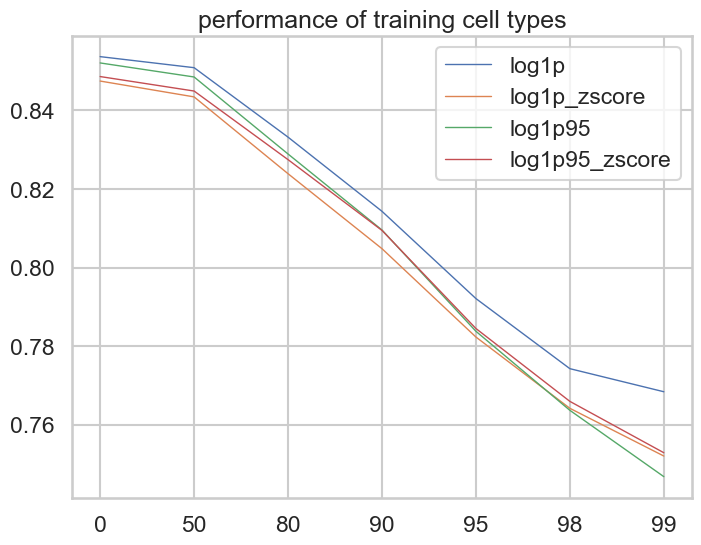

In [57]:
sns.lineplot(mean_corr_df_0[:, :3].mean(axis=1), label='log1p', linewidth=1)
sns.lineplot(mean_corr_df_4[:, :3].mean(axis=1), label='log1p_zscore', linewidth=1)
sns.lineplot(mean_corr_df_2[:, :3].mean(axis=1), label='log1p95', linewidth=1)
sns.lineplot(mean_corr_df_3[:, :3].mean(axis=1), label='log1p95_zscore', linewidth=1)
# sns.lineplot(mean_corr_df_1[:, :3].mean(axis=1), label='log1p_scale_factor', linewidth=1)
x_ticks = [0, 50, 80, 90, 95, 98, 99]
plt.xticks(np.arange(len(x_ticks)), x_ticks)
plt.title('performance of training cell types')
plt.show()

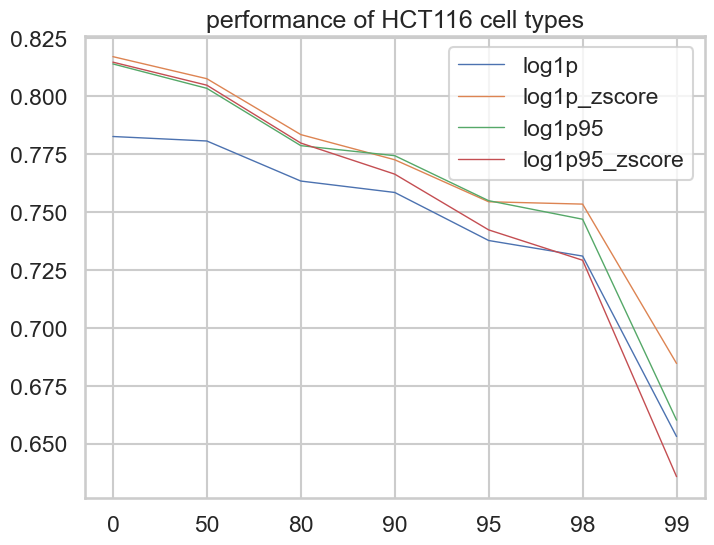

In [59]:
sns.lineplot(mean_corr_df_0[:, 3:4].mean(axis=1), label='log1p', linewidth=1)
sns.lineplot(mean_corr_df_4[:, 3:4].mean(axis=1), label='log1p_zscore', linewidth=1)
sns.lineplot(mean_corr_df_2[:, 3:4].mean(axis=1), label='log1p95', linewidth=1)
sns.lineplot(mean_corr_df_3[:, 3:4].mean(axis=1), label='log1p95_zscore', linewidth=1)
# sns.lineplot(mean_corr_df_1[:, 3:].mean(axis=1), label='log1p_scale_factor', linewidth=1)
x_ticks = [0, 50, 80, 90, 95, 98, 99]
plt.xticks(np.arange(len(x_ticks)), x_ticks)
plt.title('performance of HCT116 cell types')
plt.show()

In [ ]:
### 首先，train cell type里，log1p最好
### 其次，valid cell type里，log1p_zscore最好，log1p最差
### 这说明log1p没有消除cell types的差异，使模型学到不同的规律
### 权衡之后的结果，只好选log1p_zscore

In [11]:
y_pred = np.load(f'../saved/0916_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_log1p/0915_130556/Gosai_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [12]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_10', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.957       0.841         0.795        0.834      0.827
HepG2        0.841       0.960         0.866        0.899      0.875
SK-N-SH      0.796       0.862         0.955        0.827      0.912
HCT116       0.855       0.883         0.852        0.859      0.855
A549         0.742       0.762         0.799        0.737      0.809
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.868       0.772         0.731        0.755      0.755
HepG2        0.763       0.855         0.771        0.803      0.783
SK-N-SH      0.732       0.772         0.844        0.741      0.815
HCT116       0.781       0.802         0.761        0.783      0.774
A549         0.692       0.689         0.719        0.671      0.730
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.861       0.764         0.724        0.753      0.74

In [16]:
y_pred = np.load(f'../saved/0915_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_log1p_zscore/0915_024122/Gosai_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [17]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_10', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.955       0.841         0.802        0.852      0.830
HepG2        0.844       0.958         0.874        0.931      0.912
SK-N-SH      0.802       0.868         0.952        0.875      0.902
HCT116       0.858       0.883         0.858        0.892      0.875
A549         0.743       0.765         0.801        0.772      0.804
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.864       0.771         0.743        0.782      0.760
HepG2        0.767       0.851         0.781        0.834      0.814
SK-N-SH      0.741       0.779         0.842        0.788      0.810
HCT116       0.783       0.799         0.770        0.817      0.794
A549         0.695       0.688         0.721        0.701      0.725
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.858       0.757         0.731        0.771      0.75

In [15]:
y_pred = np.load(f'../saved/0911_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_2/0912_014514/Gosai_pred.npy')

cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [16]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.943       0.848         0.811        0.855      0.832
HepG2        0.852       0.946         0.878        0.923      0.907
SK-N-SH      0.814       0.870         0.939        0.877      0.898
HCT116       0.860       0.881         0.859        0.890      0.872
A549         0.753       0.772         0.800        0.778      0.802
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.859       0.773         0.743        0.783      0.757
HepG2        0.768       0.848         0.781        0.830      0.810
SK-N-SH      0.744       0.782         0.839        0.791      0.809
HCT116       0.783       0.799         0.770        0.817      0.791
A549         0.699       0.696         0.724        0.706      0.728
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.855       0.763         0.735        0.772      0.75

In [18]:
y_pred = np.load(f'../saved/0911_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome/0911_024110/Gosai_pred.npy')

cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [19]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.954       0.842         0.807        0.852      0.837
HepG2        0.845       0.958         0.876        0.929      0.915
SK-N-SH      0.806       0.868         0.951        0.882      0.898
HCT116       0.857       0.883         0.860        0.891      0.879
A549         0.747       0.766         0.803        0.779      0.800
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.863       0.773         0.748        0.784      0.767
HepG2        0.769       0.853         0.785        0.834      0.820
SK-N-SH      0.747       0.782         0.842        0.799      0.809
HCT116       0.785       0.801         0.773        0.819      0.798
A549         0.700       0.692         0.719        0.714      0.720
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.857       0.759         0.739        0.770      0.75

In [11]:
y_pred = np.load(f'../saved/0911_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_2/0912_014514/Gosai_pred.npy')

cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [12]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.943       0.848         0.811        0.855      0.832
HepG2        0.852       0.946         0.878        0.923      0.907
SK-N-SH      0.814       0.870         0.939        0.877      0.898
HCT116       0.860       0.881         0.859        0.890      0.872
A549         0.753       0.772         0.800        0.778      0.802
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.859       0.773         0.743        0.783      0.757
HepG2        0.768       0.848         0.781        0.830      0.810
SK-N-SH      0.744       0.782         0.839        0.791      0.809
HCT116       0.783       0.799         0.770        0.817      0.791
A549         0.699       0.696         0.724        0.706      0.728
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.855       0.763         0.735        0.772      0.75

In [16]:
y_pred = np.load(f'../saved/0911_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_95/0912_033101/Gosai_pred.npy')

cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [17]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.954       0.840         0.807        0.850      0.836
HepG2        0.846       0.957         0.877        0.927      0.914
SK-N-SH      0.804       0.867         0.950        0.884      0.899
HCT116       0.857       0.881         0.861        0.891      0.880
A549         0.742       0.763         0.802        0.783      0.802
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.863       0.768         0.747        0.780      0.765
HepG2        0.771       0.852         0.786        0.831      0.818
SK-N-SH      0.744       0.778         0.840        0.798      0.807
HCT116       0.785       0.800         0.777        0.820      0.802
A549         0.696       0.688         0.719        0.714      0.724
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.858       0.756         0.738        0.768      0.75

In [ ]:
# y_pred = np.load(f'../saved/0911_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_2/0912_014514/Gosai_pred.npy')
y_pred = np.load(f'../saved/0911_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome_95_qn/0912_035729/Gosai_pred.npy')

cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [10]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'test+diff', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.953       0.841         0.812        0.851      0.839
HepG2        0.847       0.956         0.879        0.928      0.923
SK-N-SH      0.810       0.870         0.948        0.883      0.896
HCT116       0.857       0.880         0.862        0.892      0.883
A549         0.749       0.768         0.802        0.781      0.794
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.861       0.770         0.752        0.782      0.768
HepG2        0.769       0.850         0.786        0.831      0.826
SK-N-SH      0.746       0.779         0.836        0.795      0.803
HCT116       0.783       0.797         0.777        0.820      0.804
A549         0.701       0.689         0.718        0.711      0.712
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred  A549_pred
K562         0.857       0.759         0.742        0.768      0.75

In [ ]:
# scale_log1p_zscore 0.749 0.717 差
# log1p_zscore 0.756 0.741 好？
# scale_log1p95_zscore 0.741 0.728
# log1p95_qn 0.747 0.691  差
# log1p_zscore 比 log1p95_zscore 更好

# 结论1 不要根据95百分位数归一化,确认不行
# 

In [23]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [24]:
MPRA_df = pd.read_csv('../data/Gosai_MPRA/Gosai_MPRA_seq_feature_alphagenome_scale_log1p_zscore.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,0.242,0.528,-0.163,NaN,0.189,0.062,-0.162,NaN,1.095,-0.095,-0.417,NaN,0.026,0.176,0.142,NaN,0.481,0.053,-0.041,NaN
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,0.320,0.598,-0.095,NaN,0.273,0.143,-0.089,NaN,1.298,0.014,-0.354,NaN,0.090,0.268,0.236,NaN,0.626,0.143,0.026,NaN
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,-0.073,-0.181,-0.136,NaN,0.141,0.299,-0.162,NaN,-0.506,0.450,0.332,NaN,-0.091,0.146,-0.413,NaN,-0.045,0.014,-0.009,NaN
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,-0.103,-0.169,-0.124,NaN,0.081,0.251,-0.150,NaN,-0.509,0.535,0.420,NaN,-0.077,0.146,-0.396,NaN,-0.028,0.113,0.121,NaN
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,-0.703,-0.684,-0.482,NaN,-0.414,-0.236,-0.387,NaN,-0.614,-0.138,-0.129,NaN,-0.494,-0.366,-0.573,NaN,-0.261,-0.423,-0.604,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,2.195,2.112,1.017,NaN,1.867,1.938,0.943,NaN,2.148,2.007,1.095,NaN,1.718,1.895,1.314,NaN,1.802,1.686,0.893,NaN
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,-0.266,-0.542,-0.362,NaN,-0.475,-0.523,-0.504,NaN,-0.451,-0.658,-0.545,NaN,-0.463,-0.529,-0.561,NaN,-0.399,-0.631,-0.610,NaN
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.042,-0.333,-0.136,NaN,0.286,-0.047,-0.174,NaN,-0.294,-0.156,0.102,NaN,0.164,-0.024,0.157,NaN,0.315,0.388,1.322,NaN
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,-0.213,-0.392,-0.292,NaN,-0.304,-0.326,-0.388,NaN,-0.429,-0.418,-0.290,NaN,-0.250,-0.297,-0.453,NaN,-0.393,-0.529,-0.586,NaN


In [25]:
y_pred = np.load(f'../saved/0911_Gosai_MPRA_MyCNNTransformer_seq_epi_3_cell_types_alphagenome/0911_024110/Gosai_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [26]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [7]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)


data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'


# 计算每条序列在不同细胞类型中的最大值和最小值之差
# 高差值序列为 diff，其余为 const
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
data_split_dict['diff'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 95)
data_split_dict['diff_5'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 95)
data_split_dict['diff_2'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 98)
data_split_dict['diff_1'] = MPRA_df['range'] > np.percentile(MPRA_df['range'].dropna(), 99)
data_split_dict['const'] = ~data_split_dict['diff']

# for cell_type in cell_types:
#     deviation = (MPRA_df[cell_type] - MPRA_df[['K562', 'HepG2', 'SK-N-SH']].mean(axis=1, skipna=True)).abs()
#     threshold = np.percentile(deviation.dropna(), 95)
#     data_split_dict[f'{cell_type}_specific'] = deviation > threshold



# # 找出每行最大值和最大值对应的 cell_type

# max_cell = MPRA_df[cell_types].idxmax(axis=1)

# values = MPRA_df[cell_types].to_numpy()
# values = np.where(np.isnan(values), -np.inf, values)
# max_val = np.partition(values, -1, axis=1)[:, -1]
# second_val = np.partition(values, -2, axis=1)[:, -2]

# cond2 = (max_val - second_val) > 1
# data_split_dict[f"specific"] = cond2
# for cell in cell_types:
#     data_split_dict[f"{cell}_specific"] = (max_cell == cell) & cond2


for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
diff 38034
diff_5 38034
diff_2 15214
diff_1 7607
const 722645


In [50]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [52]:
# 预测值和真实值的相关性

for data_split in ['train', 'valid', 'test', 'diff', 'test+diff', 'test+diff_5', 'test+diff_2', 'test+diff_1']:
    corr_df = pd.DataFrame()
    for cell_type in cell_types:
        for cell_type_2 in cell_types:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_2}_pred']
            r, p = pearson(x, y)
            corr_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r
    print(data_split, len(x))
    print(corr_df)




# for data_split in ['total', 'diff']:
#     corr_df = pd.DataFrame()
#     for cell_type in cell_types:
#         for cell_type_pred in cell_types_pred:
#             condition = data_split_dict[data_split]
#             condition_2 = data_split_dict[f'test']
#             df = MPRA_df[condition & condition_2]
#             x = df[f'{cell_type}']
#             y = df[f'{cell_type_pred}']
#             r, p = pearson(x, y)
#             corr_df.loc[cell_type, cell_type_pred] = r
#     print('test', data_split, len(x))
#     print(corr_df)



# for data_split in [f"{c}_specific" for c in cell_types]:
#     corr_df = pd.DataFrame()
#     for cell_type in cell_types:
#         for cell_type_pred in cell_types_pred:
#             condition = data_split_dict[data_split]
#             condition_2 = data_split_dict[f'test']
#             df = MPRA_df[condition & condition_2]
#             x = df[f'{cell_type}']
#             y = df[f'{cell_type_pred}']
#             r, p = pearson(x, y)
#             corr_df.loc[cell_type, cell_type_pred] = r
#     print('test', data_split, len(x))
#     print(corr_df)

train 631073
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred
K562         0.954       0.842         0.807        0.852
HepG2        0.845       0.958         0.876        0.929
SK-N-SH      0.806       0.868         0.951        0.882
HCT116       0.857       0.883         0.860        0.891
valid 70952
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred
K562         0.863       0.773         0.748        0.784
HepG2        0.769       0.853         0.785        0.834
SK-N-SH      0.747       0.782         0.842        0.799
HCT116       0.785       0.801         0.773        0.819
test 58654
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred
K562         0.857       0.759         0.739        0.770
HepG2        0.768       0.851         0.785        0.830
SK-N-SH      0.739       0.769         0.837        0.788
HCT116       0.790       0.798         0.779        0.816
diff 38034
         K562_pred  HepG2_pred  SK-N-SH_pred  HCT116_pred
K562         0.909       

In [11]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'



# 计算每条序列在不同细胞类型中的最大值和最小值之差
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
# 计算 range 的第95百分位
threshold = np.percentile(MPRA_df['range'].dropna(), 95)
# 前5%的高差值序列为 diff，其余为 const
data_split_dict['diff'] = MPRA_df['range'] > threshold
data_split_dict['const'] = ~data_split_dict['diff']



for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 760679
chrom 760679
designed 0
train 631073
valid 70952
test 58654
ref 389266
alt 371413
diff 38034
const 722645


In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

In [13]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac']
data_splits = ['train', 'test', 'test+diff']


for train_cell_types in [['K562'], ['HepG2'], ['SK-N-SH'], ['K562', 'HepG2'], ['K562', 'HepG2', 'SK-N-SH']]:
    # train
    train_data_split = 'train'

    X_train = []
    y_train = []
    for cell_type in train_cell_types:
        condition = data_split_dict[train_data_split]
        X_columns = [f'{cell_type}_{assay}' for assay in assays]
        y_column = cell_type
        
        X_train.append(MPRA_df.loc[condition, X_columns])
        y_train.append(MPRA_df.loc[condition, y_column])

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    print(X_train.shape, y_train.shape)


    model = LinearRegression()
    # model = MLPRegressor(hidden_layer_sizes=100, alpha=1e-3)
    model.fit(X_train, y_train)


    # valid
    pearson_df = pd.DataFrame(dtype=float)

    for cell_type in cell_types:
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            X_columns = [f'{cell_type}_{assay}' for assay in assays]
            y_column = cell_type

            X_valid = np.array(MPRA_df.loc[condition, X_columns])
            y_valid = np.array(MPRA_df.loc[condition, y_column])

            y_pred = model.predict(X_valid)

            r = pearson(y_valid, y_pred)[0]
            pearson_df.loc[cell_type, data_split] = r

    print(f'trained on {train_cell_types}')
    print(f'model architecture: LinearRegression()')
    print(pearson_df)

(631073, 3) (631073,)
trained on ['K562']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.616 0.589      0.601
HepG2    0.534 0.505      0.555
SK-N-SH  0.571 0.532      0.470
HCT116   0.577 0.560      0.567
A549     0.453 0.416      0.410
(631073, 3) (631073,)
trained on ['HepG2']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.613 0.584      0.602
HepG2    0.538 0.504      0.559
SK-N-SH  0.560 0.518      0.458
HCT116   0.579 0.559      0.571
A549     0.441 0.402      0.403
(631073, 3) (631073,)
trained on ['SK-N-SH']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.611 0.586      0.595
HepG2    0.521 0.498      0.540
SK-N-SH  0.578 0.542      0.473
HCT116   0.567 0.553      0.559
A549     0.466 0.428      0.418
(1262146, 3) (1262146,)
trained on ['K562', 'HepG2']
model architecture: LinearRegression()
         train  test  test+diff
K562     0.614 0.587      0.601
HepG2    0.535 0.504 

In [14]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac']
data_splits = ['train', 'test', 'test+diff']


for train_cell_types in [['K562'], ['HepG2'], ['SK-N-SH'], ['K562', 'HepG2'], ['K562', 'HepG2', 'SK-N-SH']]:
    # train
    train_data_split = 'train'

    X_train = []
    y_train = []
    for cell_type in train_cell_types:
        condition = data_split_dict[train_data_split]
        X_columns = [f'{cell_type}_{assay}' for assay in assays]
        y_column = cell_type
        
        X_train.append(MPRA_df.loc[condition, X_columns])
        y_train.append(MPRA_df.loc[condition, y_column])

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    print(X_train.shape, y_train.shape)

    model = MLPRegressor(hidden_layer_sizes=10, alpha=1e-3)
    model.fit(X_train, y_train)


    # valid
    pearson_df = pd.DataFrame(dtype=float)

    for cell_type in cell_types:
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            X_columns = [f'{cell_type}_{assay}' for assay in assays]
            y_column = cell_type

            X_valid = np.array(MPRA_df.loc[condition, X_columns])
            y_valid = np.array(MPRA_df.loc[condition, y_column])

            y_pred = model.predict(X_valid)

            r = pearson(y_valid, y_pred)[0]
            pearson_df.loc[cell_type, data_split] = r

    print(f'trained on {train_cell_types}')
    print(f'model architecture: MLPRegressor()')
    print(pearson_df)

(631073, 3) (631073,)
trained on ['K562']
model architecture: MLPRegressor()
         train   test  test+diff
K562     0.658  0.627      0.646
HepG2    0.549  0.518      0.605
SK-N-SH  0.300  0.228      0.243
HCT116   0.550  0.528      0.591
A549     0.057 -0.012      0.219
(631073, 3) (631073,)
trained on ['HepG2']
model architecture: MLPRegressor()
         train  test  test+diff
K562     0.635 0.602      0.606
HepG2    0.589 0.556      0.617
SK-N-SH  0.531 0.486      0.364
HCT116   0.592 0.573      0.615
A549     0.398 0.349      0.390
(631073, 3) (631073,)
trained on ['SK-N-SH']
model architecture: MLPRegressor()
         train  test  test+diff
K562     0.609 0.578      0.572
HepG2    0.567 0.537      0.576
SK-N-SH  0.604 0.571      0.522
HCT116   0.586 0.568      0.600
A549     0.470 0.445      0.455
(1262146, 3) (1262146,)
trained on ['K562', 'HepG2']
model architecture: MLPRegressor()
         train  test  test+diff
K562     0.646 0.615      0.622
HepG2    0.576 0.544      0.604